<a href="https://colab.research.google.com/github/zia207/r-colab/blob/main/NoteBook/Machine_Learning/regression_tree_r.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regression Trees in R

Zia Ahmed, University at Buffalo



A regression tree is a decision tree for predicting continuous numerical values rather than categorical ones. Like a decision tree, a regression tree consists of nodes representing input feature tests. These branches represent possible outcomes of these tests, and leaf nodes that represent final predictions.

The tree is constructed by recursively splitting the data into subsets based on the most informative feature or attribute until a stopping criterion is met. At each split, the goal is to minimize the variance of the target variable within each subset. This is typically done by finding the split that results in the most significant reduction in variance. Once the tree is constructed, it can be used to make predictions by following the path from the root node to a leaf node that corresponds to the input features. The prediction is then the mean or median of the target values of the training examples that belong to the leaf node.

Here are the steps involved in building a regression tree:

1.  Select a split point: Select a feature that will best split the data into two groups. The goal is to minimize the variance of each group. At each node, the algorithm selects a split point for one of the input variables that divides the data into two subsets, such that the variance of the target variable is minimized within each subset.

2.  Calculate the split criteria: A split criteria is calculated to determine the quality of the split. The most commonly used split criteria is the mean squared error (MSE) or the sum of squared errors (SSE).

3.  Repeat for each subset (step 1 and 2): The algorithm then recursively repeats this process on each subset until a stopping criterion is met. This stopping criterion could be a maximum tree depth or a minimum number of data points in a node.

4.  Prediction: Once the tree is built, the prediction is made by traversing the tree from the root node to a leaf node, which corresponds to a final prediction. The prediction is the mean or median value of the target variable within the leaf node.

### Install rpy2
rpy2 is an interface to R running embedded in a Python process.

In [2]:
!pip uninstall rpy2 -y
!pip install rpy2==3.5.1
%load_ext rpy2.ipython

Found existing installation: rpy2 3.4.2
Uninstalling rpy2-3.4.2:
  Successfully uninstalled rpy2-3.4.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rpy2: filename=rpy2-3.5.1-cp310-cp310-linux_x86_64.whl size=314937 sha256=88af498919ee01851a2ee22dc34ab6c1670bf144d5d3f1f9ec275c9a83a71eb4
  Stored in directory: /root/.cache/pip/wheels/73/a6/ff/4e75dd1ce1cfa2b9a670cbccf6a1e41c553199e9b25f05d953
Successfully built rpy2


### Mount Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Install Required R packages

In [4]:
%%R
pkg <- c('tidyverse', 'tidymodels', 'caret', 'Metrics', 'ggpmisc', 'vip', 'randomForest','ranger', 'rpart', 'rpart.plot')
new.packages <- pkg[!(pkg %in% installed.packages(lib='drive/My Drive/R/')[,"Package"])]
if(length(new.packages)) install.packages(new.packages, lib='drive/My Drive/R/')


### Load packages

In [6]:
%%R
# set library path
.libPaths('drive/My Drive/R')
library(tidyverse)
library(tidymodels)
library(caret)
library(rpart)
library(rpart.plot)
library(vip)
library(ggpmisc)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors



✔ dials        1.2.0     ✔ tune         1.1.1
✔ infer        1.0.4     ✔ workflows    1.1.3
✔ modeldata    1.1.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.0     ✔ yardstick    1.2.0
✔ recipes      1.0.6     

✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::step()
• Dig deeper into tidy modeling with R at https://www.tmwr.org


Attaching package: ‘caret’



    precision, recall, sensitivity, specificity



    lift


Attaching package: ‘rpart’



    prune


Attaching package: ‘vip’



    vi



Attaching package: ‘ggpp’



    annotate


  method                  from   
  as.character.polynomial polynom



### Data

In this exercise we will use following data set.

[gp_soil_data.csv](https://www.dropbox.com/s/9ikm5yct36oflei/gp_soil_data.csv?dl=0)

In [7]:
%%R
# load data from github
urlfile = "https://github.com//zia207/r-colab/raw/main/Data/USA/gp_soil_data.csv"
mf<-read_csv(url(urlfile))
# Create a data-frame
df<-mf %>% dplyr::select(SOC, DEM, Slope, TPI,MAT, MAP,NDVI, NLCD, FRG)%>%
    glimpse()

Rows: 467 Columns: 19
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (4): STATE, COUNTY, NLCD, FRG
dbl (15): ID, FIPS, STATE_ID, Longitude, Latitude, SOC, DEM, Aspect, Slope, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 467
Columns: 9
$ SOC   <dbl> 15.763, 15.883, 18.142, 10.745, 10.479, 16.987, 24.954, 6.288, 2…
$ DEM   <dbl> 2229.079, 1889.400, 2423.048, 2484.283, 2396.195, 2360.573, 2254…
$ Slope <dbl> 5.6716146, 8.9138117, 4.7748051, 7.1218114, 7.9498644, 9.6632147…
$ TPI   <dbl> -0.08572358, 4.55913162, 2.60588670, 5.14693117, 3.75570583, 6.5…
$ MAT   <dbl> 4.5951686, 3.8599243, 0.8855000, 0.4707811, 0.7588266, 1.3586667…
$ MAP   <dbl> 468.3245, 536.3522, 859.5509, 869.4724, 802.9743, 1121.2744, 610…
$ NDVI  <dbl> 0.4139390, 0.6939532, 0.5466033, 0.6191013, 0.5844722, 0.6028353…
$ NLCD  <chr> "Shrubland", "Shr

## Regression tree with rpart

The rpart package is an R package for building classification and regression trees using the Recursive Partitioning And Regression Trees (RPART) algorithm. This algorithm uses a top-down, greedy approach to recursively partition the data into smaller subsets, where each subset is homogeneous with respect to the target variable.

The rpart package provides functions for fitting and predicting with regression trees, as well as for visualizing the resulting tree. Some of the main functions in the rpart package include:

rpart(): This function is used to fit a regression or classification tree to the data. It takes a formula, a data frame, and optional arguments for controlling the tree-building process.

predict.rpart(): This function is used to predict the target variable for new data using a fitted regression or classification tree.

printcp(): This function is used to print the complexity parameter table for a fitted regression or classification tree. This table shows the cross-validated error rate for different values of the complexity parameter, which controls the size of the tree.

plot(): This function is used to visualize a fitted regression or classification tree. It produces a graphical representation of the tree with the nodes and branches labeled.

### Data Split

In [8]:
%%R
set.seed(1245)   # for reproducibility
split.df <- initial_split(df, prop = 0.8, strata = SOC)
train.df <- split.df %>% training()
test.df <-  split.df %>% testing()

### Build the initial regression tree

The rpart() function takes as input a formula specifying the target variable to be predicted and the predictors to be used in the model, as well as a data set containing the observations. It then recursively partitions the data based on the predictors, creating a tree structure in which each internal node represents a decision based on a predictor and each leaf node represents a predicted value for the target variable.

First, we'll build a large initial regression tree. We can ensure that the tree is large by using a small value for cp, which stands for "complexity parameter."

We'll then use the printcp() function to print the results of the model:

In [9]:
%%R
in.fit <- rpart(SOC ~ ., data=train.df,
              control=rpart.control(cp=.0001),
              method = "anova")

#view results
printcp(in.fit)


Regression tree:
rpart(formula = SOC ~ ., data = train.df, method = "anova", control = rpart.control(cp = 1e-04))

Variables actually used in tree construction:
[1] DEM   MAP   MAT   NDVI  Slope TPI  

Root node error: 9299.7/371 = 25.067

n= 371 

           CP nsplit rel error  xerror     xstd
1  0.26043041      0   1.00000 1.01148 0.115282
2  0.08739231      1   0.73957 0.76861 0.091215
3  0.03981695      2   0.65218 0.71171 0.089400
4  0.02968373      3   0.61236 0.72457 0.087274
5  0.02772462      4   0.58268 0.72593 0.086536
6  0.01720801      5   0.55495 0.69395 0.079646
7  0.01431336      6   0.53774 0.71741 0.082321
8  0.01427435      7   0.52343 0.71149 0.082248
9  0.01138460      9   0.49488 0.70991 0.082360
10 0.00941973     10   0.48350 0.71513 0.084972
11 0.00828430     11   0.47408 0.71070 0.084374
12 0.00726562     12   0.46579 0.71850 0.084522
13 0.00668445     14   0.45126 0.74686 0.085528
14 0.00656314     15   0.44458 0.73642 0.083937
15 0.00514674     17   0.43145

We can use the plotcp() function to visualize the cross-validated error for each level of tree complexity:

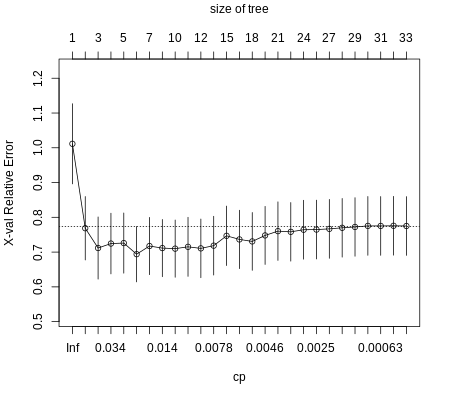

In [10]:
%%R -w 450 -h 400 -u px
plotcp(in.fit)

### Prune the tree

Pruning is a technique used to reduce the size of a regression tree by removing some of the branches that do not contribute much to the prediction accuracy. Pruning can help to avoid overfitting and improve the generalization performance of the model.

Next, we'll prune the regression tree to find the optimal value to use for cp (the complexity parameter) that leads to the lowest test error. Use the prune() function to prune the tree to the desired complexity level. For example, to prune the tree to the level with the lowest cross-validated error.

Note that the optimal value for cp is the one that leads to the lowest xerror in the previous output, which represents the error on the observations from the cross-validation data.

First, #identify best cp value to use:

In [11]:
%%R
best_cp <-in.fit$cptable[which.min(in.fit$cptable[,"xerror"]),"CP"]
best_cp

[1] 0.01720801


We use use this cp value to prune the tree:

In [12]:
%%R
pruned.fit <- rpart::prune(in.fit, cp = best_cp)
summary(pruned.fit)

Call:
rpart(formula = SOC ~ ., data = train.df, method = "anova", control = rpart.control(cp = 1e-04))
  n= 371 

          CP nsplit rel error    xerror       xstd
1 0.26043041      0 1.0000000 1.0114796 0.11528232
2 0.08739231      1 0.7395696 0.7686088 0.09121486
3 0.03981695      2 0.6521773 0.7117057 0.08939984
4 0.02968373      3 0.6123603 0.7245669 0.08727429
5 0.02772462      4 0.5826766 0.7259339 0.08653580
6 0.01720801      5 0.5549520 0.6939516 0.07964616

Variable importance
 NDVI   MAP   DEM Slope   MAT   FRG  NLCD   TPI 
   36    19    15    10     6     6     5     2 

Node number 1: 371 observations,    complexity param=0.2604304
  mean=6.324235, MSE=25.06656 
  left son=2 (296 obs) right son=3 (75 obs)
  Primary splits:
      NDVI  < 0.5842654 to the left,  improve=0.2604304, (0 missing)
      MAP   < 532.8792  to the left,  improve=0.2155606, (0 missing)
      Slope < 7.58043   to the left,  improve=0.1564041, (0 missing)
      DEM   < 2224.082  to the left,  improve=

We can use rpart.plot() function to plot  the regression tree:

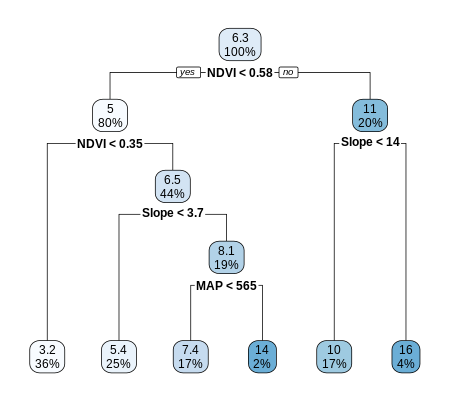

In [13]:
%%R -w 450 -h 400 -u px
rpart.plot(pruned.fit)

### Prediction

In [14]:
%%R
test.df$SOC.tree<-predict(pruned.fit, test.df)

In [15]:
%%R
RMSE<- Metrics::rmse(test.df$SOC, test.df$SOC.tree)
RMSE

[1] 3.522476


`geom_smooth()` using formula = 'y ~ x'


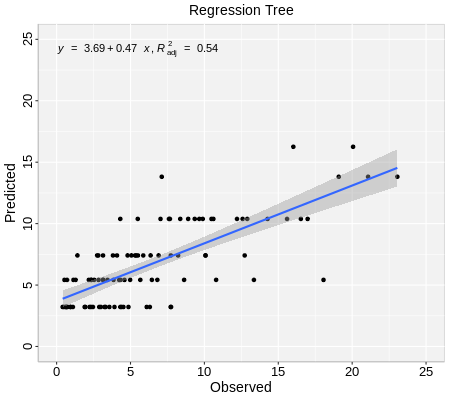

In [16]:
%%R -w 450 -h 400 -u px

formula<-y~x

ggplot(test.df, aes(SOC,SOC.tree)) +
  geom_point() +
  geom_smooth(method = "lm")+
  stat_poly_eq(use_label(c("eq", "adj.R2")), formula = formula) +
  ggtitle("Regression Tree") +
  xlab("Observed") + ylab("Predicted") +
  scale_x_continuous(limits=c(0,25), breaks=seq(0, 25, 5))+
  scale_y_continuous(limits=c(0,25), breaks=seq(0, 25, 5)) +
  # Flip the bars
  theme(
    panel.background = element_rect(fill = "grey95",colour = "gray75",size = 0.5, linetype = "solid"),
    axis.line = element_line(colour = "grey"),
    plot.title = element_text(size = 14, hjust = 0.5),
    axis.title.x = element_text(size = 14),
    axis.title.y = element_text(size = 14),
    axis.text.x=element_text(size=13, colour="black"),
    axis.text.y=element_text(size=13,angle = 90,vjust = 0.5, hjust=0.5, colour='black'))

## Regression Tree with caret package

#### Set control parameters

In [17]:
%%R
set.seed(123)
train.control <- trainControl(method = "repeatedcv",
                              number = 10, repeats = 5,
                              preProc = c("center", "scale", "nzv"))

### Train the model

In [18]:
%%R
set.seed(2)
train.rpart <- caret::train(SOC ~., data = train.df,
                     method = "rpart",
                     tuneLength = 50,
                     trControl = train.control ,
                     tuneGrid = expand.grid(cp = seq(0,0.4,0.01)))

In [19]:
%%R
train.rpart

CART 

371 samples
  8 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 334, 333, 334, 334, 334, 334, ... 
Resampling results across tuning parameters:

  cp    RMSE      Rsquared      MAE     
  0.00  4.509316  2.769299e-01  3.231612
  0.01  4.323208  3.072242e-01  3.032395
  0.02  4.257813  3.158449e-01  2.998006
  0.03  4.314825  2.956942e-01  3.049286
  0.04  4.294635  2.931849e-01  3.022898
  0.05  4.253645  3.052001e-01  3.017513
  0.06  4.201570  3.150752e-01  3.011249
  0.07  4.173444  3.175855e-01  3.004081
  0.08  4.222658  3.033084e-01  3.043568
  0.09  4.388515  2.488704e-01  3.191270
  0.10  4.405598  2.423928e-01  3.243067
  0.11  4.405598  2.423928e-01  3.243067
  0.12  4.405598  2.423928e-01  3.243067
  0.13  4.405598  2.423928e-01  3.243067
  0.14  4.405598  2.423928e-01  3.243067
  0.15  4.405598  2.423928e-01  3.243067
  0.16  4.405598  2.423928e-01  3.243067
  0.17  4.405598  2.423928e-01  3.243067
  0.18

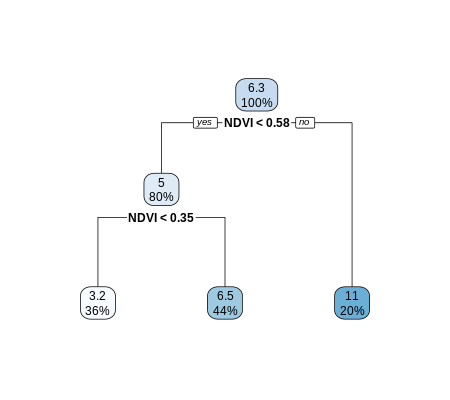

In [20]:
%%R -w 450 -h 400 -u px
rpart.plot(train.rpart$finalModel)

## Regression Tree with tidymodel

The tidymodels provides a comprehensive framework for building, tuning, and fit regression tree models while following the principles of the tidyverse.


### Data split

In [21]:
%%R
set.seed(1245)   # for reproducibility
split <- initial_split(df, prop = 0.8, strata = SOC)
train <- split %>% training()
test <-  split %>% testing()

# Set 10 fold cross-validation data set
cv_folds <- vfold_cv(train, v = 10)


### Create Recipe

A recipe is a description of the steps to be applied to a data set in order to prepare it for data analysis. Before training the model, we can use a recipe to do some preprocessing required by the model.

In [22]:
%%R
tree_recipe <-
  recipe(SOC ~ ., data = train) %>%
  step_zv(all_predictors()) %>%
  step_dummy(all_nominal()) %>%
  step_normalize(all_numeric_predictors())

### Specify tunable decision tree model

decision_tree() from parsnip package (installed with tidymodels) defines a model as a set of ⁠if/then⁠ statements that creates a tree-based structure. This function can fit classification, regression, and censored regression models. We will use **rpart** to create a regression tree model

In [23]:
%%R
tree_model<- decision_tree(
  cost_complexity = tune(),
  tree_depth = tune(),
  min_n = tune()
) %>%
  set_engine("rpart") %>%
  set_mode("regression")
tree_model

Decision Tree Model Specification (regression)

Main Arguments:
  cost_complexity = tune()
  tree_depth = tune()
  min_n = tune()

Computational engine: rpart 



### Define workflow

In [24]:
%%R
tree_wf <- workflow() %>%
  add_recipe(tree_recipe) %>%
  add_model(tree_model)

### Define possible grid parameter


In [25]:
%%R
tree_grid <- grid_regular(cost_complexity(),
                          tree_depth(),
                          min_n(),
                          levels = 4)
head(tree_grid)

# A tibble: 6 × 3
  cost_complexity tree_depth min_n
            <dbl>      <int> <int>
1    0.0000000001          1     2
2    0.0000001             1     2
3    0.0001                1     2
4    0.1                   1     2
5    0.0000000001          5     2
6    0.0000001             5     2


### Model tuning via grid search

Now we will fit the models with all the possible parameter values on all our resampled (cv.fold) datasets. tune_grid() of tune package (installed with tidymodels) computes a set of performance metrics (e.g. accuracy or RMSE) for a pre-defined set of tuning parameters that correspond to a model or recipe across one or more resamples of the data.

tune_grid() computes a set of performance metrics (e.g. accuracy or RMSE) for a pre-defined set of tuning parameters that correspond to a model or recipe across one or more resamples of the data.


In [33]:
%%R
set.seed(345)
tree_tune <- tune_grid(
  tree_wf,
  resamples = cv_folds,
  grid = tree_grid,
  metrics = metric_set(rmse, rsq, mae, mape)
)
tree_tune

# Tuning results
# 10-fold cross-validation 
# A tibble: 10 × 4
   splits           id     .metrics           .notes          
   <list>           <chr>  <list>             <list>          
 1 <split [333/38]> Fold01 <tibble [256 × 7]> <tibble [0 × 3]>
 2 <split [334/37]> Fold02 <tibble [256 × 7]> <tibble [0 × 3]>
 3 <split [334/37]> Fold03 <tibble [256 × 7]> <tibble [0 × 3]>
 4 <split [334/37]> Fold04 <tibble [256 × 7]> <tibble [0 × 3]>
 5 <split [334/37]> Fold05 <tibble [256 × 7]> <tibble [0 × 3]>
 6 <split [334/37]> Fold06 <tibble [256 × 7]> <tibble [0 × 3]>
 7 <split [334/37]> Fold07 <tibble [256 × 7]> <tibble [0 × 3]>
 8 <split [334/37]> Fold08 <tibble [256 × 7]> <tibble [0 × 3]>
 9 <split [334/37]> Fold09 <tibble [256 × 7]> <tibble [0 × 3]>
10 <split [334/37]> Fold10 <tibble [256 × 7]> <tibble [0 × 3]>


### Evaluate model

collect_metrics() of tune package (installed with tidymodels) obtain and format results by tuneing function:

In [34]:
%%R
collect_metrics(tree_tune)

# A tibble: 256 × 9
   cost_complexity tree_depth min_n .metric .estimator    mean     n std_err
             <dbl>      <int> <int> <chr>   <chr>        <dbl> <int>   <dbl>
 1    0.0000000001          1     2 mae     standard     3.19     10  0.175 
 2    0.0000000001          1     2 mape    standard   103.       10  8.73  
 3    0.0000000001          1     2 rmse    standard     4.29     10  0.307 
 4    0.0000000001          1     2 rsq     standard     0.255    10  0.0282
 5    0.0000001             1     2 mae     standard     3.19     10  0.175 
 6    0.0000001             1     2 mape    standard   103.       10  8.73  
 7    0.0000001             1     2 rmse    standard     4.29     10  0.307 
 8    0.0000001             1     2 rsq     standard     0.255    10  0.0282
 9    0.0001                1     2 mae     standard     3.19     10  0.175 
10    0.0001                1     2 mape    standard   103.       10  8.73  
# ℹ 246 more rows
# ℹ 1 more variable: .config <chr>
# ℹ

we can also visualize the tuning parameters:

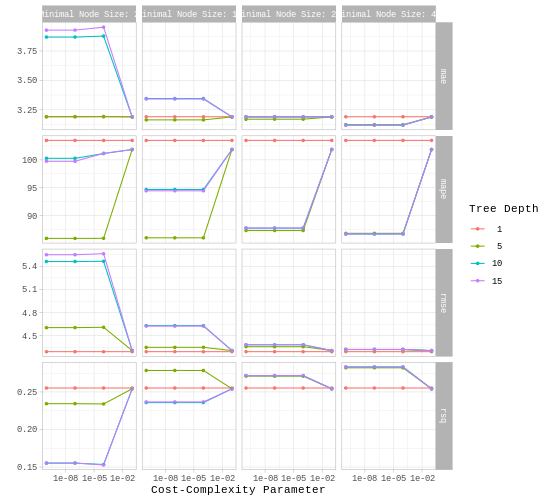

In [37]:
%%R -w 550 -h 500 -u px
autoplot(tree_tune) + theme_light(base_family = "IBMPlexSans")

### The best tuning parameters

show_best() of tune package displays the top sub-models and their performance estimates.

In [38]:
%%R
show_best(tree_tune, "rmse")

# A tibble: 5 × 9
  cost_complexity tree_depth min_n .metric .estimator  mean     n std_err
            <dbl>      <int> <int> <chr>   <chr>      <dbl> <int>   <dbl>
1    0.0000000001          1     2 rmse    standard    4.29    10   0.307
2    0.0000001             1     2 rmse    standard    4.29    10   0.307
3    0.0001                1     2 rmse    standard    4.29    10   0.307
4    0.1                   1     2 rmse    standard    4.29    10   0.307
5    0.0000000001          1    14 rmse    standard    4.29    10   0.307
# ℹ 1 more variable: .config <chr>


select_best() finds the tuning parameter combination with the best performance values.

In [30]:
%%R
select_best(tree_tune, "rmse")

# A tibble: 1 × 4
  cost_complexity tree_depth min_n .config              
            <dbl>      <int> <int> <chr>                
1    0.0000000001          1     2 Preprocessor1_Model01


### Final model

In [39]:
%%R
tree_final <- finalize_model(tree_model, select_best(tree_tune, "rmse"))
tree_final

Decision Tree Model Specification (regression)

Main Arguments:
  cost_complexity = 1e-10
  tree_depth = 1
  min_n = 2

Computational engine: rpart 



We can either fit final_tree to training data using fit() or to the testing/training split using last_fit(), which will give us some other results along with the fitted output.

In [40]:
%%R
final_fit <- fit(tree_final, SOC ~ .,train)
final_reg <- last_fit(tree_final, SOC ~ ., split)

In [41]:
%%R
collect_metrics(final_reg)

# A tibble: 2 × 4
  .metric .estimator .estimate .config             
  <chr>   <chr>          <dbl> <chr>               
1 rmse    standard       4.50  Preprocessor1_Model1
2 rsq     standard       0.243 Preprocessor1_Model1


### Prediction

In [42]:
%%R
predict(final_fit,test)

# A tibble: 96 × 1
   .pred
   <dbl>
 1 11.4 
 2 11.4 
 3 11.4 
 4  5.04
 5  5.04
 6  5.04
 7  5.04
 8  5.04
 9  5.04
10  5.04
# ℹ 86 more rows
# ℹ Use `print(n = ...)` to see more rows


### Variable importance plot

vip() function can plot variable importance scores for the predictors in a model.

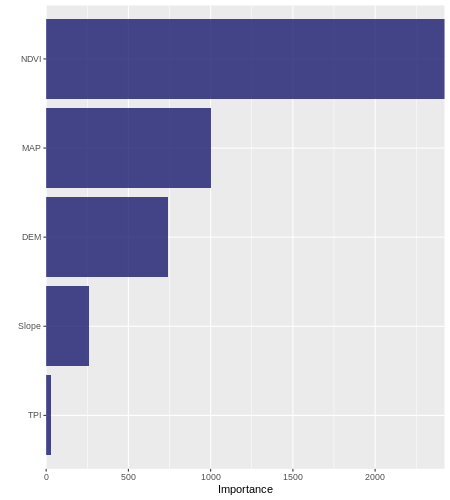

In [44]:
%%R -w 450 -h 500 -u px
final_fit %>%
  vip(geom = "col", aesthetics = list(fill = "midnightblue", alpha = 0.8)) +
  scale_y_continuous(expand = c(0, 0))

### Further Reading

1.  [Tune and interpret decision trees for #TidyTuesday wind turbines](https://juliasilge.com/blog/wind-turbine/)

2.  [ISLR8 - Decision Trees in R (Regression)](https://rstudio-pubs-static.s3.amazonaws.com/446972_323b4475ff0749228fe4057c4d7685f5.html)

3.  https://www.r-bloggers.com/2021/04/decision-trees-in-r/

### YouTube Video

1.  Visual Guide to Regression Trees

{{< video https://www.youtube.com/watch?v=g9c66TUylZ4 >}}

Source: [StatQuest with Josh Starme](https://www.youtube.com/@statquest)
